In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import Counter

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create train,test and validation datasets
data_dir = 'https://drive.google.com/drive/folders/1jJ7TTKbpxXbXJEhy4mJ32Dd0G9W6JAfa?usp=share_link'
train_valid_data = datasets.ImageFolder('/content/drive/MyDrive/AIP/Assignment_1/classification_dataset/train',data_transforms['train'])
train_data,valid_data = random_split(train_valid_data,[0.85,0.15], generator=torch.Generator().manual_seed(42))
test_data = datasets.ImageFolder('/content/drive/MyDrive/AIP/Assignment_1/classification_dataset/test',data_transforms['test'])

In [3]:
image_datasets = {'train' : train_data, 'val' : valid_data, 'test' : test_data}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = train_valid_data.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cpu')

(906, 1810, 3)


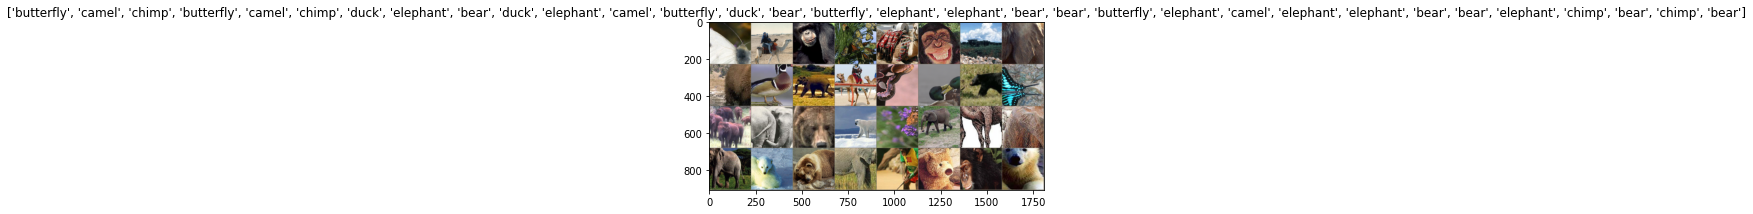

In [26]:
# Visualize the images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
dataset_sizes

{'train': 453, 'val': 79, 'test': 120}

In [14]:
# Hyperparameters
num_classes = len(class_names)
learning_rate = 0.0001
batch_size = 32
epochs = 20

In [7]:
class ConvNet(nn.Module):
  def __init__(self):
      super(ConvNet, self).__init__()
      self.flatten = nn.Flatten()
      self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
      self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
      self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
      
      self.fc1 = nn.LazyLinear(128)
      self.relu = nn.ReLU()
      self.drop = nn.Dropout(0.6)
      self.fc2 = nn.LazyLinear(num_classes)

  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.flatten(out)
      out = self.fc1(out)
      out = self.relu(out)
      out = self.drop(out)
      out = self.fc2(out)
      return out

In [18]:
model = ConvNet().to(device)

In [9]:
X = torch.rand(32,3,224,224).to(device)
model(X).shape

torch.Size([32, 6])

In [10]:
model

ConvNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (rel

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # keeps track of best_model for every epoch that performs better on val dataset
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Keep track of losses and accuracy in each epoch
    losses = {'train':[],'val':[]}
    acc = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,losses,acc

In [21]:
model,loss,acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=epochs)

Epoch 0/19
----------
train Loss: 2.1486 Acc: 0.1854
val Loss: 1.7816 Acc: 0.2025

Epoch 1/19
----------
train Loss: 1.7833 Acc: 0.1898
val Loss: 1.7343 Acc: 0.3165

Epoch 2/19
----------
train Loss: 1.7293 Acc: 0.2715
val Loss: 1.6875 Acc: 0.2658

Epoch 3/19
----------
train Loss: 1.7427 Acc: 0.2406
val Loss: 1.6984 Acc: 0.3291

Epoch 4/19
----------
train Loss: 1.7264 Acc: 0.2848
val Loss: 1.7013 Acc: 0.2785

Epoch 5/19
----------
train Loss: 1.7174 Acc: 0.2561
val Loss: 1.6503 Acc: 0.3924

Epoch 6/19
----------
train Loss: 1.7217 Acc: 0.2539
val Loss: 1.6629 Acc: 0.3165

Epoch 7/19
----------
train Loss: 1.7003 Acc: 0.2561
val Loss: 1.6707 Acc: 0.2532

Epoch 8/19
----------
train Loss: 1.6995 Acc: 0.2649
val Loss: 1.6718 Acc: 0.2532

Epoch 9/19
----------
train Loss: 1.6891 Acc: 0.2826
val Loss: 1.6901 Acc: 0.2785

Epoch 10/19
----------
train Loss: 1.6925 Acc: 0.2781
val Loss: 1.6533 Acc: 0.3038

Epoch 11/19
----------
train Loss: 1.6930 Acc: 0.2340
val Loss: 1.6630 Acc: 0.2785

Ep

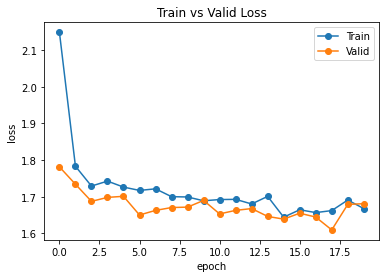

In [22]:
plt.plot(torch.tensor(loss['train']).numpy(),'-o')
plt.plot(torch.tensor(loss['val']).numpy(),'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
 
plt.show()

In [23]:
# Testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy of the model on the test images: 40.0 %


In [27]:
def visualize_model(model, num_images=2):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

(224, 224, 3)


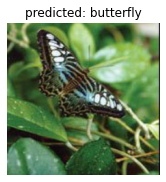

(224, 224, 3)


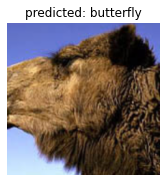

In [28]:
visualize_model(model)